In [14]:
# Load dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [15]:
# Load data
data = pd.read_csv("heart.csv")

In [16]:
# Step 1: Handling Missing Values
# Check for missing values in the dataset
print("Missing values before imputation:\n", data.isnull().sum())

Missing values before imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [17]:
# Impute missing values (if any)
for col in data.columns:
    if data[col].dtype == 'object':  # For categorical data, use mode
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:  # For numerical data, use mean
        data[col].fillna(data[col].mean(), inplace=True)

print("Missing values after imputation:\n", data.isnull().sum())

Missing values after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


<ipython-input-17-2774ba8c0b7e>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


In [18]:
# Step 2: Scaling Data
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

print("\nData after standardization (Z-score):")
print(data[numerical_features].head())

minmax_scaler = MinMaxScaler()
data[numerical_features] = minmax_scaler.fit_transform(data[numerical_features])

print("\nData after Min-Max Scaling:")
print(data[numerical_features].head())


Data after standardization (Z-score):
        age  trestbps      chol   thalach   oldpeak
0 -0.268437 -0.377636 -0.659332  0.821321 -0.060888
1 -0.158157  0.479107 -0.833861  0.255968  1.727137
2  1.716595  0.764688 -1.396233 -1.048692  1.301417
3  0.724079  0.936037 -0.833861  0.516900 -0.912329
4  0.834359  0.364875  0.930822 -1.874977  0.705408

Data after Min-Max Scaling:
        age  trestbps      chol   thalach   oldpeak
0  0.479167  0.292453  0.196347  0.740458  0.161290
1  0.500000  0.433962  0.175799  0.641221  0.500000
2  0.854167  0.481132  0.109589  0.412214  0.419355
3  0.666667  0.509434  0.175799  0.687023  0.000000
4  0.687500  0.415094  0.383562  0.267176  0.306452


In [19]:
# Step 3: Handling Outliers
# Detect outliers in 'chol' using Z-score
data['chol_zscore'] = (data['chol'] - data['chol'].mean()) / data['chol'].std()
outliers = data[np.abs(data['chol_zscore']) > 3]

print("\nOutliers detected:\n", outliers)

# Handle outliers by capping
data['chol_capped'] = data['chol']
data.loc[np.abs(data['chol_zscore']) > 3, 'chol_capped'] = data['chol'].mean()

print("\nOutliers handled:")
print(data[['chol', 'chol_zscore', 'chol_capped']].head())


Outliers detected:
           age  sex  cp  trestbps      chol  fbs  restecg   thalach  exang  \
123  0.750000    0   2  0.433962  0.664384    1        0  0.656489      0   
158  0.791667    0   2  0.198113  1.000000    0        0  0.679389      0   
179  0.562500    0   0  0.377358  0.646119    0        0  0.603053      1   
192  0.791667    0   2  0.198113  1.000000    0        0  0.679389      0   
450  0.708333    0   0  0.528302  0.641553    0        0  0.633588      0   
464  0.791667    0   2  0.198113  1.000000    0        0  0.679389      0   
481  0.708333    0   0  0.528302  0.641553    0        0  0.633588      0   
641  0.562500    0   0  0.377358  0.646119    0        0  0.603053      1   
665  0.750000    0   2  0.433962  0.664384    1        0  0.656489      0   
685  0.708333    0   0  0.528302  0.641553    0        0  0.633588      0   
889  0.708333    0   0  0.528302  0.641553    0        0  0.633588      0   
958  0.750000    0   2  0.433962  0.664384    1        

In [20]:
# Step 4: Feature Selection
features = ['age', 'trestbps', 'chol_capped', 'thalach', 'oldpeak']
target = data['target']

In [21]:
# Mutual Information
mi = mutual_info_classif(data[features], target)
print("\nMutual Information:\n", pd.Series(mi, index=features))


Mutual Information:
 age            0.074045
trestbps       0.068471
chol_capped    0.264314
thalach        0.164638
oldpeak        0.144079
dtype: float64


In [22]:
# Backward RFE
model = RandomForestClassifier(random_state=42)
rfe = RFE(model, n_features_to_select=3)
rfe.fit(data[features], target)
print("\nRFE Selected Features:\n", pd.Series(rfe.support_, index=features))


RFE Selected Features:
 age             True
trestbps       False
chol_capped    False
thalach         True
oldpeak         True
dtype: bool


In [23]:
# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(data[features], target)
lasso_importance = np.abs(lasso.coef_)
print("\nLasso Feature Importance:\n", pd.Series(lasso_importance, index=features))


Lasso Feature Importance:
 age            0.0
trestbps       0.0
chol_capped    0.0
thalach        0.0
oldpeak        0.0
dtype: float64


In [24]:
# Comparison of feature selection methods
comparison = pd.DataFrame({
    'Feature': features,
    'Mutual Information': mi,
    'RFE Selected': rfe.support_,
    'Lasso Importance': lasso_importance
})

print("\nFeature Comparison:\n", comparison)


Feature Comparison:
        Feature  Mutual Information  RFE Selected  Lasso Importance
0          age            0.074045          True               0.0
1     trestbps            0.068471         False               0.0
2  chol_capped            0.264314         False               0.0
3      thalach            0.164638          True               0.0
4      oldpeak            0.144079          True               0.0


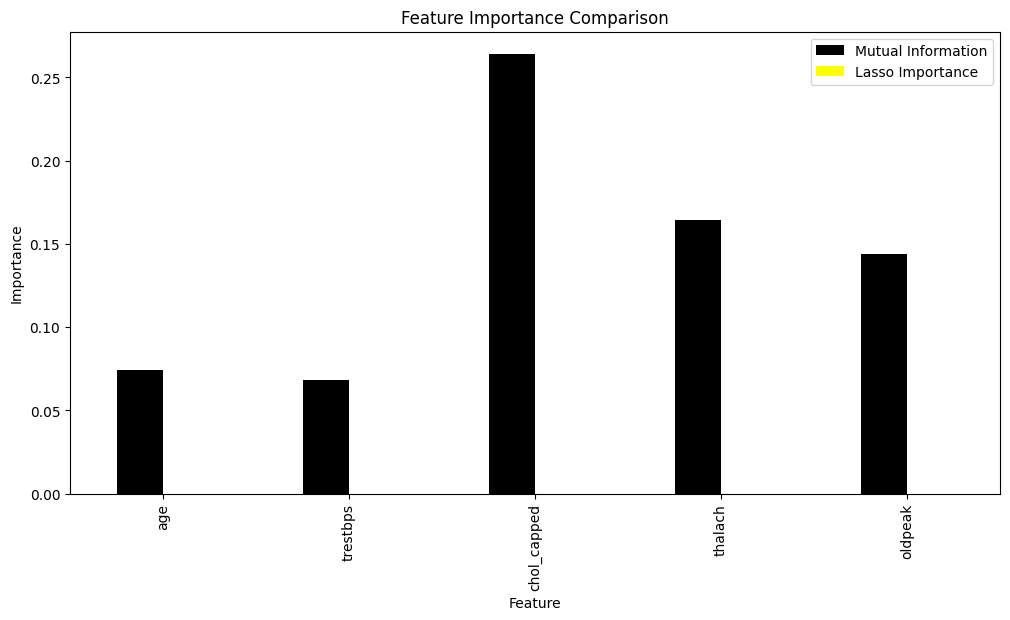

In [25]:
# Plot feature importance
comparison.set_index('Feature').plot(kind='bar', figsize=(12, 6), color=['black', 'yellow', 'red'])
plt.title("Feature Importance Comparison")
plt.ylabel("Importance")
plt.show()